<h1 style="font-size:30px;">Encoding Labels using Anchors</h1>

**The encoder block in the pipeline:**

<img src='https://opencv.org/wp-content/uploads/2022/06/encoding_v2.png' width=700>
<img src='https://opencv.org/wp-content/uploads/2022/06/pipeline_config_v3.png' width=700>



We are already familiar with encoding ground truth using the anchors' concept. In this notebook, we will go into the coding of it.

## Table of Contents

* [1 Generating Anchors Across Scales and Aspect Ratios](#1-Generating-Anchors-Across-Scales-and-Aspect-Ratios)
* [2 Encoding Ground-Truth wrt Anchors](#2-Encoding-Ground-Truth-wrt-Anchors)
* [3 The DataEncoder Class](#3-The-DataEncoder-Class)

In [ ]:
# required imports
import os
import requests
from zipfile import ZipFile
import tensorflow as tf
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Download Dependencies


Let's download the script, `encoder_scripts/general_encoder.py`

**The below code cell has a method for downloading a file.**

In [ ]:
def download_file(url, save_name):
    """
    "Download and save the file."

    arguments:
    url (str): URL path of the file.
    save_name: (str): file path to save the downloaded file.
    """
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)
    print(f"Downloaded {save_name}...")
    return

**The below method can use to unzip a zipped file.**

In [ ]:
def unzip(zip_file_path=None):
    """
    "Unzip the file"

    arguments:
    zip_file_path (str): The zipped file path

    """
    try:
        with ZipFile(zip_file_path) as z:
            z.extractall("./")
            print(f"Extracted {zip_file_path}...\n")
    except:
        print("Invalid file")

    return

In [ ]:
if not os.path.exists('encoder_scripts'):
    download_file(
                  'https://www.dropbox.com/s/n6itt4qbitj8xce/encoder_scripts.zip?dl=1',
                  'encoder_scripts.zip'
                 )

    unzip('encoder_scripts.zip')

Downloaded encoder_scripts.zip...
Extracted encoder_scripts.zip...



After downloading and unzipping, the following folders and files should be there:

**folders:** `encoder_scripts`

**files:** `encoder_scripts/general_encoder.py`, `encoder_scripts/encoder.py` and `encoder_scripts/train_boxes.csv`

However, only `encoder_scripts/general_encoder.py` will be used in the notebook. The rest two will be used in the next encoding notebook.

Let's verify it by running the below cell.

In [ ]:
os.listdir("./encoder_scripts")

['train_boxes.csv', 'encoder.py', 'general_encoder.py']

## 1 Generating Anchors Across Scales and Aspect Ratios

**RECAP**

<img src = 'https://learnopencv.com/wp-content/uploads/2021/08/multiple_anchors.jpg' width=700>


Remember that we have a 3 x 3 feature map (virtually, we divided the image into a `3 x 3` grid). So, for each grid cell in the feature map, we have `3` anchors with the same area and different aspect ratios $1/2$, $1$ and $2$. Using three scales helped us to encode all objects in the image.

Also, remember that the image area was `600 x 600`, and the anchor area was `200 x 200` (`600 / 3 = 200`).

So instead of fixing the anchor area, we can also change it to a different scale.






### Scales and Aspect Ratios

In this notebook, we have taken an example of `3` scales and `3` aspect ratios for each scale. The scales and aspect ratios are as follows:

- Scales: $1, 2^{1/3}$ and $2^{2/3}$
- Aspect ratios: $1/2$, $1$ and $2$

So, the total number of anchors per grid cell is `3 x 3 = 9`.

### Anchors Area

The above scales and aspect ratios will be applied to fixed anchor areas.

**What anchor area should we choose?**

Do recall the input of `loc_head` and `cls_head` for `300 x 300` images from the last detector NN architecture notebook.

The inputs shapes of `loc_head` and `cls_head`(`DetectorHead`):
```
(None, 38, 38, 32)   # FPN output 1 / input 1
(None, 19, 19, 32)   # FPN output 2 / input 2
(None, 10, 10, 32)   # FPN output 3 / input 3
(None, 5, 5, 32)     # emb_1 output / input 4
(None, 3, 3, 32)     # emb_2 output / input 5

```

So it is a good idea to consider these five-level feature maps to calculate the anchor area for these five levels. Further, let us imagine the FPN output feature `(None, 38, 38, 32)` represents a `38 x 38` grid in the original input image. Similarly, `(None, 19, 19, 32)` represents a `19 x 19` grid in the original image. So we can calculate the anchor area for each output level with this notion.

So the anchor area we can choose as follows:


```
300 / 38 = 7.89, let's approximate it to 8
300 / 19 = 15.79, approximate it to 16
300 / 10 = 30, approximate it to 32 to make it 2 to the power something
300 / 5 = 60, approximate it to 64
300 / 3 = 100, approximate it to 128
```
Finally, the anchors' area is as follows:
```
[8 x 8, 16 x 16, 32 x 32, 64 x 64, 128 x 128]
```

**Note that there is no hard and fast rule to calculate the anchor area. Also, there is no fix rule for choosing scales and aspect ratios. In the next notebook, we will see that we have chosen anchors using `k-mean` clustering (an advanced notebook on anchor choice).**




### Generate Anchors

These five anchors area is for the five FPN output level. So let us generate nine different anchors for each area.

let us assume,

$\text{height} = h$,

$\text{width} = w$,

$\text{anchor_area} = a$,

$\text{aspect_ratio} = r = \frac{w}{h}$

and , $\text{ scale} = s$

hence,


\begin{align}
r &= \frac{w}{h} \\
\Rightarrow  w &= r.h
\end{align}

Now,

\begin{align}
a &= w . h \\
\Rightarrow a &= r.h.h \\
\Rightarrow h^2 &= \frac{a}{r} \\
\Rightarrow h &= \sqrt{\frac{a}{r}}
\end{align}

As, $scale$ is $s$,

the $\text{ new_height} = s.h = s. \sqrt{\frac{a}{r}}$

and the $ \text{new_width} = r. \text{new_height}$


The `generate_anchors(...)` function generates anchors for different scales and aspect ratios centered at the origin.

In [ ]:
def generate_anchors(anchor_area, aspect_ratios, scales):
    """
    Generate anchors for different scales and aspect ratios centered at the
    origin.
    """
    anchors = []

    for scale in scales:
        for ratio in aspect_ratios:

            h = scale * (math.sqrt(anchor_area / ratio))  # h*w * h/w = sqrt(h**2)
            w = ratio * h  # w/h * h

            # Assume the anchor box is centered at origin (0, 0)
            # Get xmin, ymin, xmax, ymax of anchor box w.r.t origin (0, 0)
            box_w_half = w / 2
            box_h_half = h / 2

            xmin = 0.0 - box_w_half
            ymin = 0.0 - box_h_half

            xmax = 0.0 + box_w_half
            ymax = 0.0 + box_h_half

            anchors.append([xmin, ymin, xmax, ymax])

    return tf.convert_to_tensor(anchors)

Let us generate anchors for `3rd-level` features. Its base anchor area is `32 x 32`. Let's generate `9` anchors using `3` scales and `3` aspect ratios.

In [ ]:
anchor_areas = [8 * 8, 16 * 16, 32 * 32, 64 * 64, 128 * 128]
anchor_area = 32 * 32
aspect_ratios = [1/2, 1, 2]
scales = [1, math.pow(2, 1/3), math.pow(2, 2/3)]
anchors = generate_anchors(anchor_area, aspect_ratios, scales)

Let us visualize these anchors on one of the grid-cell centers in the original image shape (`300 x 300`).

For this, we'll write a helper class, `Visualize`.  

In [ ]:
class Visualize:
    def __init__(self, img_shape=(300, 300, 3), num_grid_cells=(10, 10),
                 fig_size=(8, 8), linewidth=1):
        self.blank = np.ones(shape=img_shape, dtype=np.uint8)*255
        self.img_shape = img_shape
        self.grid_size = (img_shape[0]//num_grid_cells[0],
                          img_shape[1]//num_grid_cells[1])
        self.fig_size = fig_size
        self.linewidth = linewidth

        # colors in CV2
        red = (0, 0, 255)
        green = (0, 255, 0)
        blue = (255, 0, 0)
        self.colors = [red, green, blue]

        self.anchor_num = 0

    def get_color(self):
        anchor_num = self.anchor_num % 9
        index = 0
        if anchor_num >= 3 and anchor_num < 6:
            index = 1
        elif anchor_num >= 6:
            index = 2
        return self.colors[index]

    @staticmethod
    def bgr_to_rgb(img):
        return img[:, :, ::-1]

    def add_anchors(self, anchors):
        for i, box in enumerate(anchors):
            topleft = tuple(map(int, box.numpy()[0:2].tolist()))
            bottomright = tuple(map(int, box.numpy()[2:].tolist()))
            color = self.get_color()
            cv2.rectangle(self.blank, topleft, bottomright, color,
                          self.linewidth)
            self.anchor_num += 1
        return

    def add_center(self, center):
        cv2.circle(self.blank, center, 1, (0, 0, 0), -1)
        return

    def imshow(self):
        img = self.bgr_to_rgb(self.blank)
        plt.figure(figsize=self.fig_size)
        plt.xticks(range(0, self.img_shape[1] + self.grid_size[1],
                         self.grid_size[1]))
        plt.yticks(range(0, self.img_shape[0] + self.grid_size[0],
                         self.grid_size[0]))
        plt.grid("true")

        plt.imshow(img)
        plt.show()

Now let us visualize anchors for the anchor base area `32 x 32`. This base area is for the `3rd-level` features, where feature width-height is `10 x 10`. So let us divide the image into `10 x 10` grid cells.

Also, the generated anchors' center is `(0, 0)`. So instead of plotting it at `(0, 0)`, let's plot in one of the grid-cell centers, for example, `(135, 135)` (center of `grid-cell-(5, 5)`). For this, we need to add the center offset to all anchor coordinates. So let us write a helper function `add_offset_to_anchors` for the same.

In [ ]:
def add_offset_to_anchors(anchors, anchor_center):
    updated_anchors = anchors + tf.constant([anchor_center[0], anchor_center[1],
                                       anchor_center[0], anchor_center[1]],
                                       dtype=tf.float32)
    return updated_anchors

Let us visualize anchors at the anchor center `(135, 135)`.

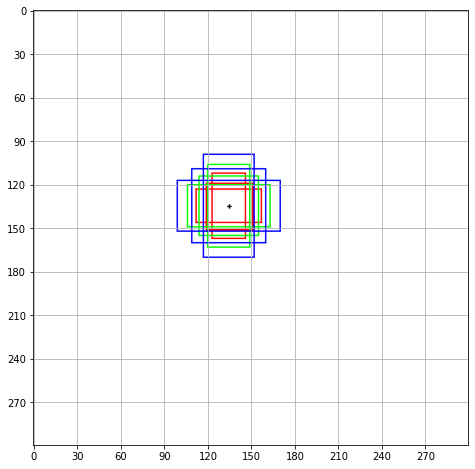

In [ ]:
vis = Visualize(num_grid_cells=(10, 10))
anchor_center = (135, 135)
# update the anchors position
anchors = add_offset_to_anchors(anchors, anchor_center)
vis.add_anchors(anchors)
vis.add_center(anchor_center)
vis.imshow()

Let us also generate anchors for the 4th level feature where the anchor base area is `64 x 64` and the number of features is `5 x 5` (so the number of grid cells is `5 x 5`).

Let us visualize the anchors at the anchor center `(150, 90)`.

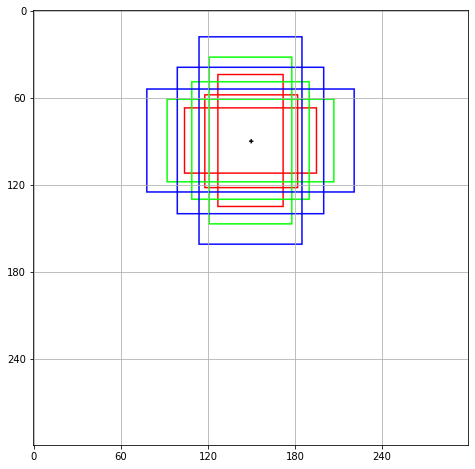

In [ ]:
anchor_area = 64 * 64
anchors = generate_anchors(anchor_area, aspect_ratios, scales)
anchor_center = (150, 90)
# update the anchors position
anchors = add_offset_to_anchors(anchors, anchor_center)
vis = Visualize(num_grid_cells=(5, 5))
vis.add_anchors(anchors)
vis.add_center(anchor_center)
vis.imshow()

### Generate Anchors for all Grid-cells

Once anchors for a given grid (feature-level) are generated, we have to place them at all grid-cells centers.

Also, note that if anchors are placed at the edges cell center, a portion of the anchor may fall outside of the image. So we need to handle these cases by clipping anchors to the image area.

So let us write a function `generate_anchor_grid` for the same.

In [ ]:
def generate_anchor_grid(input_size, fm_size, anchors):
    """
    Generate anchors for all grid-cless

    Arguments:
    input_size (tuple): The imput image shape
    fm_size (tuple): tuple of feature height-width
    anchors (tensors): All anchors for the feature-level

    return: anchors for all grid cells, centered at the grid-cell center
    """
    img_h, img_w = input_size

    grid_h = math.ceil(img_h / fm_size)
    grid_w = math.ceil(img_w / fm_size)

    grid_h_coords = tf.range(0, fm_size, dtype=tf.float32) * grid_h + grid_h / 2
    grid_w_coords = tf.range(0, fm_size, dtype=tf.float32) * grid_w + grid_w / 2

    x, y = tf.meshgrid(grid_w_coords, grid_h_coords)

    xyxy = tf.cast(tf.stack([x, y, x, y], axis=2), tf.float32)
    anchors = tf.reshape(anchors, [-1, 1, 1, 4])
    boxes = tf.transpose(xyxy + anchors, perm=(1, 2, 0, 3))
    boxes = tf.reshape(boxes, [-1, 4])

    # clip anchors to image area
    min_anchor_size = [0.0, 0.0, 0.0, 0.0]
    max_anchor_size = [img_w, img_h, img_w, img_h]

    boxes = tf.clip_by_value(boxes, clip_value_min=min_anchor_size, clip_value_max=max_anchor_size)

    return boxes

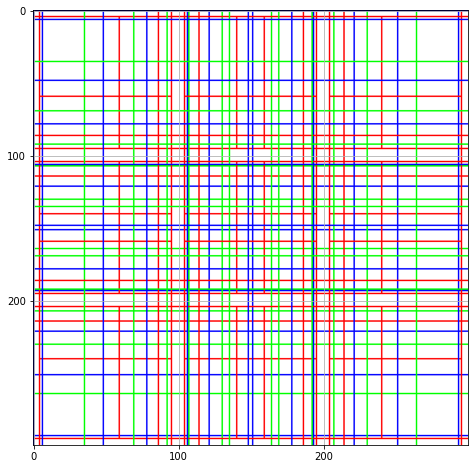

In [ ]:
anchor_area = 128 * 128
num_grid_cells = (3, 3)  # number of grid-cells for the anchor area
                         # (128 x 128) is (3 x 3)
anchors = generate_anchors(anchor_area, aspect_ratios, scales)
fm_size = 3
input_size = (300, 300)  # image height-width
all_anchors = generate_anchor_grid(input_size, fm_size, anchors)
vis = Visualize(num_grid_cells=num_grid_cells)
start_idx = 0
end_idx = 81
vis.add_anchors(all_anchors[start_idx:end_idx])
vis.imshow()
#all_anchors[start_idx:end_idx]

So far, anchors have been generated; the next step is to assign a label to anchors and adjust anchors' coordinates to match ground-truth labels.

## 2 Encoding Ground-Truth wrt Anchors

In the classification to detection module, we have seen how anchors will be assigned a label based on IoU with ground truth. Moreover, if the anchor is assigned some object label (not a background label), then anchor coordinates will be adjusted to match the ground truth.

Here is the flow diagram of the algorithm.

**RECAP**

<img src = 'https://opencv.org/wp-content/uploads/2022/06/iou_flowchart.png' width=700>


Broadly the label assigned to the anchor can be divided into two parts:

- Assigning a class label, and
- Adjustments in anchors (offset) to match with ground truth.


In code, the assignment of the class label is the same as shown in the diagram. However, an adjustment in the anchor is not a simple difference between the anchor and ground truth coordinates. Instead, it has a different representation.

So, let us first have a look into the bounding box encoding of ground truths.

### Bounding Box Encoding

Before going into encoding, let us look at an alternate representation of rectangle (anchor/ground truth).

So far, we have seen that the following four numbers can represent a rectangle (bounding box):

$[x_{min}, y_{min}, x_{max}, y_{max}]$

Using these four numbers, we can calculate the following four numbers and vice-versa:

$[x_{center}, y_{center}, width, height]$

where,

$(x_{center}, y_{center})$ is the center of the rectangle.

$width$ is width of the rectangle.

$height$ is height of the rectangle.

We can get the alternate representation using the old representation as follows:

\begin{align}
x_{center} &= x_{min} + \frac{x_{max} - x_{min}}{2} \\
y_{center} &= y_{min} + \frac{y_{max} - y_{min}}{2}\\
width &= x_{max} - x_{min} \\
height &= y_{max} - y_{min}
\end{align}







In the old representation:

**Anchor:** $[x_{Amin}, y_{Amin}, x_{Amax}, y_{Amax}]$

**Ground-truth:** $[x_{gt \ min}, y_{gt\ min}, x_{gt\ max}, y_{gt\ max}]$

The below image represents an anchor and a ground truth box plotted in `green` and `red` respectively.



<img src = "https://opencv.org/wp-content/uploads/2022/06/encoding_gts.png" width =700>

**One of the encodings can be as follows:**

$$
\begin{align}
dx_{center} & = \ \frac{x_{gt\ center} - x_{Acenter}}{width_A}\\
\nonumber\\dy_{center} & = \ \frac{y_{gt\ center} - y_{Acenter}}{height_A}\\
\nonumber\\dwidth & = \ \ln{\left[\frac{width_{gt}}{width_A}\right]}\\
\nonumber\\dheight & = \ \ln{\left[\frac{height_{gt}}{height_A}\right]}\\
\end{align}
$$






**Is the new encoding better than the old (naive) encoding?**

**YES**

To understand it, let us take an example of an anchor and ground truth.

**Case I:**

$Anchor_{old}: [10, 10, 20, 20]$

$Ground-truth_{old}: [12, 12, 22, 22]$

$Anchor_{new}: [15, 15, 10, 10]$

$Ground-truth_{new}: [17, 17, 10, 10]$

Then,

$$
IoU = \frac{8 * 8}{(10*10)+(10*10)-(8*8)} = \frac{64}{136} = \frac{8}{17}
$$

**Offset encoding using the old method:** $[2, 2, 2, 2]$

**Offset encoding using the new method:** $[\frac{2}{10}, \frac{2}{10}, \ln{\frac{1}{1}}, \ln{\frac{1}{1}}]$

**Case II:**

$Anchor_{old}: [5, 5, 10, 10]$

$Ground-truth_{old}: [6, 6, 11, 11]$

$Anchor_{new}: [7.5, 7.5, 5, 5]$

$Ground-truth_{new}: [8.5, 8.5, 5, 5]$

Then,

$$
IoU = \frac{4 * 4}{(5*5)+(5*5)-(4*4)} = \frac{16}{34} = \frac{8}{17}
$$

**Offset encoding using the old method:** $[1, 1, 1, 1]$

**Offset encoding using the new method:** $[\frac{1}{5}, \frac{1}{5}, \ln{\frac{1}{1}}, \ln{\frac{1}{1}}]$

We notice that IoU and new offsets are the same in both cases. However, the old offsets are different. Moreover, the old offset for the bigger anchor-gt pair is more compared to the smaller pair. It means that if we are encoding using old offset, generally model has to learn bigger offset values for bigger anchor-gt pair. So it is not normalizing throughout the all anchors area. However, the new offsets are normalized across all anchor areas.


There is a nice [blog post](https://leimao.github.io/blog/Bounding-Box-Encoding-Decoding/) that discusses the various encoding schemes used in object detection.

We have discussed the bounding box offset encoding in detail. Now let us jump to the code for box encoding, `encode_boxes`.

```python
def encode_boxes(*, boxes, anchors):
    anchors_wh = anchors[:, 2:] - anchors[:, :2]
    anchors_ctr = anchors[:, :2] + 0.5 * anchors_wh
    boxes_wh = boxes[:, 2:] - boxes[:, :2]
    boxes_ctr = boxes[:, :2] + 0.5 * boxes_wh

    encoded_xy = (boxes_ctr - anchors_ctr) / anchors_wh
    encoded_wh = tf.math.log(boxes_wh / anchors_wh)

    boxes = tf.concat([encoded_xy, encoded_wh], axis=1)

    return boxes
```

### Class Encoding

Class encoding is the same as shown in the above flow chart.

In summary following is the algorithm for a class assignment:

anchor in all anchors:
- calculate IoU with all ground-truth
- select the ground truth which has maximum IoU
- if IoU > 0.5, assign the class to the anchor
- elif IoU > 0.3, assign -1 , don't care class
- else, assign 0, the background class

Now let us jump to the code encoding that includes class and bounding box encoding.



```python
def encode(self, boxes, classes):
        iou = compute_iou(src=boxes, dst=self.anchor_boxes)
        ids = tf.math.argmax(iou, axis=1)
        iou = tf.math.reduce_max(iou, axis=1)

        loc_targets = encode_boxes(boxes=tf.gather(boxes, ids), anchors=self.anchor_boxes)

        cls_targets = tf.gather(classes, ids)
        cls_targets = tf.where(iou < 0.5, -1, cls_targets)
        cls_targets = tf.where(iou < 0.3, 0, cls_targets)

        return loc_targets, cls_targets
```

# 3 The DataEncoder Class

The DataEncoder class is the class for encoding and decoding. Let us use the class for a sample encoding.

In [ ]:
from encoder_scripts.general_encoder import DataEncoder

height_width = (300, 300)
bbox = tf.constant([[100, 100, 130, 200], [120, 110, 150, 200]], dtype=tf.float32)
classes = tf.constant([1, 1], dtype=tf.float32)

data_encoder = DataEncoder(height_width, classes=["__background__", "person"])

loc_traget, cls_target = data_encoder.encode(bbox, classes)

print('Location Target Shape: {}'.format(loc_traget.shape))
print('Class Target Shape (sparse): {}'.format(cls_target.shape))

Location Target Shape: (17451, 4)
Class Target Shape (sparse): (17451,)


Most probably, you are not wondering about the number 17451. The number comes from all nine anchors at all grid cells at all feature level.

If you are wondering about class target shape, why is it not `(17451, 2)` for two classes?

Because it is sparsely encoded, using one-hot encoding further, it can be changed to `(17451, 2)`.
